# Zero to RAPIDS in Minutes

_Compare CPU (scikit-learn) to GPU (cuML) for training random forest models_

This example shows the speed difference between using a CPU versus a GPU to train a random forest machine learning model. To test the CPU, the
popular machine learning package scikit-learn is used, while for the GPU the RAPIDS framework from NVIDIA is used. It also compares using a Dask cluster running multiple machines with GPUs for even more power when training.

For more context of this comparison you can find the details on the [RAPIDS blog post](https://developer.nvidia.com/blog/zero-to-rapids-in-minutes-with-nvidia-gpus-saturn-cloud/).

## Set up the experiment

To set up the experiment, the context manager is set up to measure recording timings. In a separate chunk the comparison data is downloaded. It's large csv file of New York taxi data.

In [1]:
from time import time
from contextlib import contextmanager

times = []


@contextmanager
def timing(description: str) -> None:
    start = time()
    yield
    elapsed = time() - start
    times.append((description, elapsed))
    print(f"{description}: {round(elapsed)} seconds")

In [2]:
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  655M  100  655M    0     0  19.4M      0  0:00:33  0:00:33 --:--:-- 39.3M


## Test the CPU with scikit-learn

The next chunk computes the time to read the csv in with pandas and then run the scikit-learn random forest model training function.

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFCPU

with timing("CPU: CSV Load"):
    taxi_cpu = pd.read_csv(
        "data.csv",
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    )

X_cpu = taxi_cpu[["PULocationID", "DOLocationID", "passenger_count"]].fillna(-1)
y_cpu = taxi_cpu["tip_amount"] > 1

rf_cpu = RFCPU(n_estimators=100, n_jobs=-1)

with timing("CPU: Random Forest"):
    _ = rf_cpu.fit(X_cpu, y_cpu)

CPU: CSV Load: 13 seconds
CPU: Random Forest: 337 seconds


## Test the GPU with RAPIDS

This section uses the `cudf` and `cuml` packages, part of RAPIDS, which perform their loading and model fitting computations using the GPU. You'll notice this runs far faster than the CPU training, while having similar syntax.

In [4]:
import cudf
from cuml.ensemble import RandomForestClassifier as RFGPU

with timing("GPU: CSV Load"):
    taxi_gpu = cudf.read_csv(
        "data.csv",
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    )

X_gpu = taxi_gpu[["PULocationID", "DOLocationID", "passenger_count"]].astype("float32").fillna(-1)
y_gpu = (taxi_gpu["tip_amount"] > 1).astype("int32")

rf_gpu = RFGPU(n_estimators=100)

with timing("GPU: Random Forest"):
    _ = rf_gpu.fit(X_gpu, y_gpu)

GPU: CSV Load: 3 seconds
GPU: Random Forest: 23 seconds


## Comparing results results

Finally, we compare the results visually using matplotlib.

In [5]:
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

df = pd.DataFrame(times, columns=["description", "Seconds"])
df[["Hardware", "task"]] = df.description.str.split(": ", 1, expand=True)

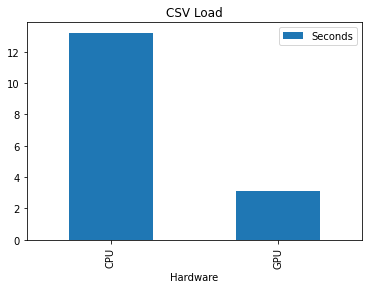

In [6]:
df[df.task == "CSV Load"].plot(
    title="CSV Load",
    kind="bar",
    x="Hardware",
    y="Seconds",
);

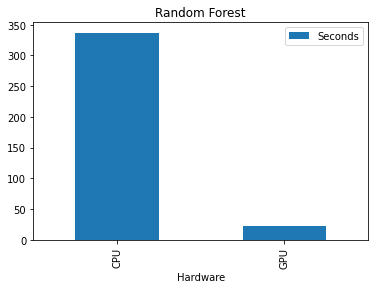

In [7]:
df[df.task == "Random Forest"].plot(
    title="Random Forest",
    kind="bar",
    x="Hardware",
    y="Seconds",
);

# Bonus: train a model with more data with a Dask cluster

This final section of code by using a cluster of machines (each with a GPU) to train a model together with RAPIDS. This allows you to still quickly train models but no longer be limited to data that can fit on a single machine.

This code will train a model on approximately **12x the data** as the other two, but still run as nearly quickly as with a single GPU.

In [9]:
from dask.distributed import Client, wait
from dask_saturn import SaturnCluster
import dask_cudf
from cuml.dask.ensemble import RandomForestClassifier as RFDask

cluster = SaturnCluster()
client = Client(cluster)

In [11]:
with timing("GPU + Dask: Random Forest (12x the data)"):
    taxi_dask = dask_cudf.read_csv(
        "s3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv",
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
        storage_options={"anon": True},
        assume_missing=True,
    )

    X_dask = (
        taxi_dask[["PULocationID", "DOLocationID", "passenger_count"]].astype("float32").fillna(-1)
    )
    y_dask = (taxi_dask["tip_amount"] > 1).astype("int32")

    X_dask, y_dask = client.persist([X_dask, y_dask])
    _ = wait(X_dask)

    rf_dask = RFDask(n_estimators=100)
    _ = rf_dask.fit(X_dask, y_dask)

GPU + Dask: Random Forest: 32 seconds


## Conclusion

As the example showed, a model using RAPIDS can be trained far more quickly than one on a CPU. RAPIDS can also run far more quickly by using Dask to connect multiple machines together.